In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import deque
import pickle

In [2]:
class OptimizedMaze:
    def __init__(self, maze, start_position, goal_position):
        self.maze = maze
        self.maze_height = maze.shape[0]
        self.maze_width = maze.shape[1]
        self.start_position = start_position
        self.goal_position = goal_position
        
        # Pre-compute distances for reward shaping
        self.distance_map = self._compute_distance_map()
    
    def _compute_distance_map(self):
        """Compute Manhattan distance from each cell to the goal"""
        distance_map = np.zeros((self.maze_height, self.maze_width))
        for i in range(self.maze_height):
            for j in range(self.maze_width):
                if self.maze[i][j] != 1:  # If not a wall
                    distance_map[i][j] = abs(i - self.goal_position[1]) + abs(j - self.goal_position[0])
        return distance_map

    def show_maze(self, path=None, q_values=None):
        plt.figure(figsize=(8, 8))
        plt.imshow(self.maze, cmap='gray')
        
        # Plot path if provided
        if path:
            path = np.array(path)
            plt.plot(path[:, 0], path[:, 1], 'b-', linewidth=2, alpha=0.7)
            plt.plot(path[:, 0], path[:, 1], 'b.', markersize=10)
        
        # Plot Q-values if provided
        if q_values is not None:
            for i in range(self.maze_height):
                for j in range(self.maze_width):
                    if self.maze[i][j] != 1:  # If not a wall
                        max_q = np.max(q_values[j, i])
                        plt.text(j, i, f'{max_q:.1f}', ha='center', va='center', color='red', alpha=0.5)
        
        plt.text(self.start_position[0], self.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[0], self.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [3]:
# Define maze layout
maze_layout = np.array([
    [0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [1, 1, 1, 0, 1, 0, 0, 0, 1, 0],
    [0, 0, 1, 0, 1, 1, 1, 0, 1, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 1, 1, 1, 1, 0],
    [0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
])

# Update the start and goal positions
start_position = (0, 0)  # Top-left corner
goal_position = (9, 9)    # Bottom-right corner

maze = OptimizedMaze(maze_layout, start_position, goal_position)

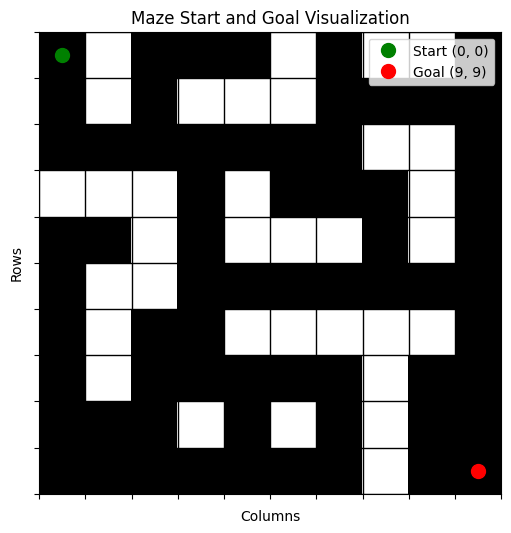

In [4]:
# Create the maze visualization
def visualize_start_goal(maze_layout, start, goal):
    plt.figure(figsize=(6, 6))
    
    # Show the maze
    plt.imshow(maze_layout, cmap='gray', origin='upper')

    # Highlight start position
    plt.plot(start[1], start[0], 'go', markersize=10, label='Start (0, 0)')

    # Highlight goal position
    plt.plot(goal[1], goal[0], 'ro', markersize=10, label='Goal (9, 9)')

    plt.title('Maze Start and Goal Visualization')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.xticks(np.arange(-0.5, maze_layout.shape[1], 1), [])
    plt.yticks(np.arange(-0.5, maze_layout.shape[0], 1), [])
    plt.grid(color='black', linestyle='-', linewidth=1)
    plt.legend()
    plt.show()

# Call the visualization function
visualize_start_goal(maze_layout, start_position, goal_position)

In [5]:
class ImprovedQLearningAgent:
    def __init__(self, maze, learning_rate=0.1, discount_factor=0.95, exploration_start=1.0, exploration_end=0.05, num_episodes=1000):
        self.q_table = np.zeros((maze.maze_height, maze.maze_width, 4))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_start = exploration_start
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes
        
        # Experience replay buffer
        self.replay_buffer = deque(maxlen=10000)
        self.batch_size = 32
        
        # Separate target network for stability
        self.target_q_table = self.q_table.copy()
        self.target_update_frequency = 100
        
        # Prioritized sweeping parameters
        self.priority_threshold = 0.1
        self.priority_queue = []
    
    def get_exploration_rate(self, current_episode):
        # Slower exponential decay of exploration rate
        return self.exploration_end + (self.exploration_start - self.exploration_end) * \
               np.exp(-3 * current_episode / self.num_episodes)
    
    def get_action(self, state, current_episode):
        exploration_rate = self.get_exploration_rate(current_episode)
        
        if np.random.rand() < exploration_rate:
            return np.random.randint(4)
        
        # Boltzmann exploration (softmax) for better action selection
        q_values = self.q_table[state]
        temperature = max(0.1, 1.0 - current_episode / self.num_episodes)
        exp_q = np.exp(q_values / temperature)
        probs = exp_q / np.sum(exp_q)
        return np.random.choice(4, p=probs)
    
    def update_q_table(self, state, action, next_state, reward, done):
        # Store experience in replay buffer
        self.replay_buffer.append((state, action, next_state, reward, done))
        
        # Perform experience replay
        if len(self.replay_buffer) >= self.batch_size:
            self._experience_replay()
    
    def _experience_replay(self):
        # Sample batch from replay buffer
        batch = np.random.choice(len(self.replay_buffer), self.batch_size, replace=False)
        for idx in batch:
            state, action, next_state, reward, done = self.replay_buffer[idx]
            
            # Double Q-learning update
            if not done:
                next_action = np.argmax(self.q_table[next_state])
                next_q = self.target_q_table[next_state][next_action]
                target = reward + self.discount_factor * next_q
            else:
                target = reward
            
            # Update Q-value
            current_q = self.q_table[state][action]
            self.q_table[state][action] += self.learning_rate * (target - current_q)
            
            # Add to priority queue if error is significant
            error = abs(target - current_q)
            if error > self.priority_threshold:
                self.priority_queue.append((error, state, action))
    
    def update_target_network(self):
        self.target_q_table = self.q_table.copy()

In [6]:
def enhanced_reward_function(state, next_state, maze, done, steps):
    """Enhanced reward function with distance-based shaping"""
    if done:
        return 500 / (steps + 1)  # Goal reached with steps-based reward
    
    if next_state == state:  # Hit wall or invalid move
        return -5
    
    # Distance-based reward shaping
    current_distance = maze.distance_map[state[1]][state[0]]
    next_distance = maze.distance_map[next_state[1]][next_state[0]]
    distance_reward = 2 * (current_distance - next_distance)  # Increased weight
    
    # Smaller time penalty
    time_penalty = -0.05 * steps
    
    # Add small negative reward to encourage faster goal-reaching
    move_penalty = -0.1
    
    return distance_reward + time_penalty + move_penalty


In [7]:
# Define the possible actions: [right, down, left, up]
actions = [
    (0, 1),   # right
    (1, 0),   # down
    (0, -1),  # left
    (-1, 0)   # up
]


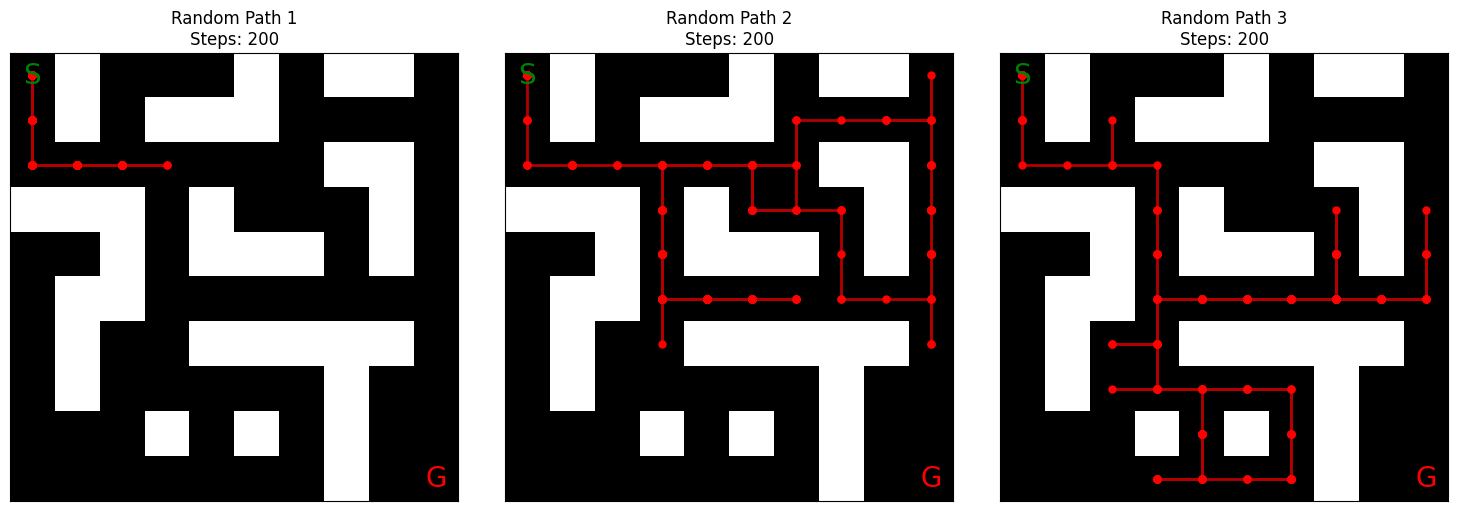

In [8]:
def visualize_untrained_path(maze, num_paths=3):
    plt.figure(figsize=(15, 5))
    
    # Create an untrained agent
    untrained_agent = ImprovedQLearningAgent(maze)
    
    # Show multiple random paths
    for i in range(num_paths):
        plt.subplot(1, 3, i+1)
        current_state = maze.start_position
        path = [current_state]
        steps = 0
        
        while steps < 200:  # Limit steps to avoid infinite loops
            # Get random action (exploration rate is 1.0 for untrained agent)
            action = untrained_agent.get_action(current_state, current_episode=0)
            
            # Calculate next state
            next_state = (
                current_state[0] + actions[action][0],
                current_state[1] + actions[action][1]
            )
            
            # Check if move is valid
            if (next_state[0] < 0 or next_state[0] >= maze.maze_width or
                next_state[1] < 0 or next_state[1] >= maze.maze_height or
                maze.maze[next_state[1]][next_state[0]] == 1):
                next_state = current_state
                
            current_state = next_state
            path.append(current_state)
            steps += 1
            
            if current_state == maze.goal_position:
                break
        
        # Plot the maze
        plt.imshow(maze.maze, cmap='gray')
        
        # Plot the path
        path = np.array(path)
        plt.plot(path[:, 0], path[:, 1], 'r-', linewidth=2, alpha=0.7)
        plt.plot(path[:, 0], path[:, 1], 'r.', markersize=10)
        
        # Mark start and goal
        plt.text(maze.start_position[0], maze.start_position[1], 'S', 
                ha='center', va='center', color='green', fontsize=20)
        plt.text(maze.goal_position[0], maze.goal_position[1], 'G', 
                ha='center', va='center', color='red', fontsize=20)
        
        plt.title(f'Random Path {i+1}\nSteps: {steps}')
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.show()

# Visualize random paths before training
visualize_untrained_path(maze)

In [9]:
def train_improved_agent(agent, maze, num_episodes=1000):
    episode_rewards = []
    episode_steps = []
    best_episode_steps = float('inf')
    best_path = None

    for episode in range(num_episodes):
        current_state = maze.start_position
        episode_reward = 0
        steps = 0
        path = [current_state]

        while True:
            action = agent.get_action(current_state, episode)
            next_state = (
                current_state[0] + actions[action][0],
                current_state[1] + actions[action][1]
            )

            # Check if move is valid
            if (next_state[0] < 0 or next_state[0] >= maze.maze_width or
                next_state[1] < 0 or next_state[1] >= maze.maze_height or
                maze.maze[next_state[1]][next_state[0]] == 1):
                next_state = current_state

            done = next_state == maze.goal_position
            reward = enhanced_reward_function(current_state, next_state, maze, done, steps)

            agent.update_q_table((current_state[0], current_state[1]), action,
                               (next_state[0], next_state[1]), reward, done)

            current_state = next_state
            episode_reward += reward
            steps += 1
            path.append(current_state)

            if done or steps > 100:  # Add step limit to prevent infinite loops
                break

        # Update target network periodically
        if episode % agent.target_update_frequency == 0:
            agent.update_target_network()

        # Store best path
        if done and steps < best_episode_steps:
            best_episode_steps = steps
            best_path = path

        episode_rewards.append(episode_reward)
        episode_steps.append(steps)

        # Print progress
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_steps = np.mean(episode_steps[-100:])
            print(f"Episode {episode + 1}/{num_episodes}, "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"Avg Steps: {avg_steps:.2f}, "
                  f"Best Steps: {best_episode_steps}")

    return episode_rewards, episode_steps, best_path

In [10]:
def visualize_training_results(episode_rewards, episode_steps):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(episode_rewards)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    plt.subplot(1, 3, 2)
    plt.plot(episode_steps)
    plt.title('Steps per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    
    # Plot moving averages
    window_size = 50
    plt.subplot(1, 3, 3)
    plt.plot(np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid'),
             label='Rewards (MA)')
    plt.plot(np.convolve(episode_steps, np.ones(window_size)/window_size, mode='valid'),
             label='Steps (MA)')
    plt.title(f'Moving Average (window={window_size})')
    plt.xlabel('Episode')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Episode 100/1000, Avg Reward: -311.79, Avg Steps: 94.40, Best Steps: 42
Episode 200/1000, Avg Reward: -176.67, Avg Steps: 71.38, Best Steps: 27
Episode 300/1000, Avg Reward: -55.10, Avg Steps: 45.12, Best Steps: 19
Episode 400/1000, Avg Reward: -19.41, Avg Steps: 36.82, Best Steps: 19
Episode 500/1000, Avg Reward: 18.73, Avg Steps: 26.87, Best Steps: 18
Episode 600/1000, Avg Reward: 29.91, Avg Steps: 23.74, Best Steps: 18
Episode 700/1000, Avg Reward: 37.92, Avg Steps: 21.92, Best Steps: 18
Episode 800/1000, Avg Reward: 40.25, Avg Steps: 21.49, Best Steps: 18
Episode 900/1000, Avg Reward: 42.69, Avg Steps: 20.56, Best Steps: 18
Episode 1000/1000, Avg Reward: 44.21, Avg Steps: 20.08, Best Steps: 18


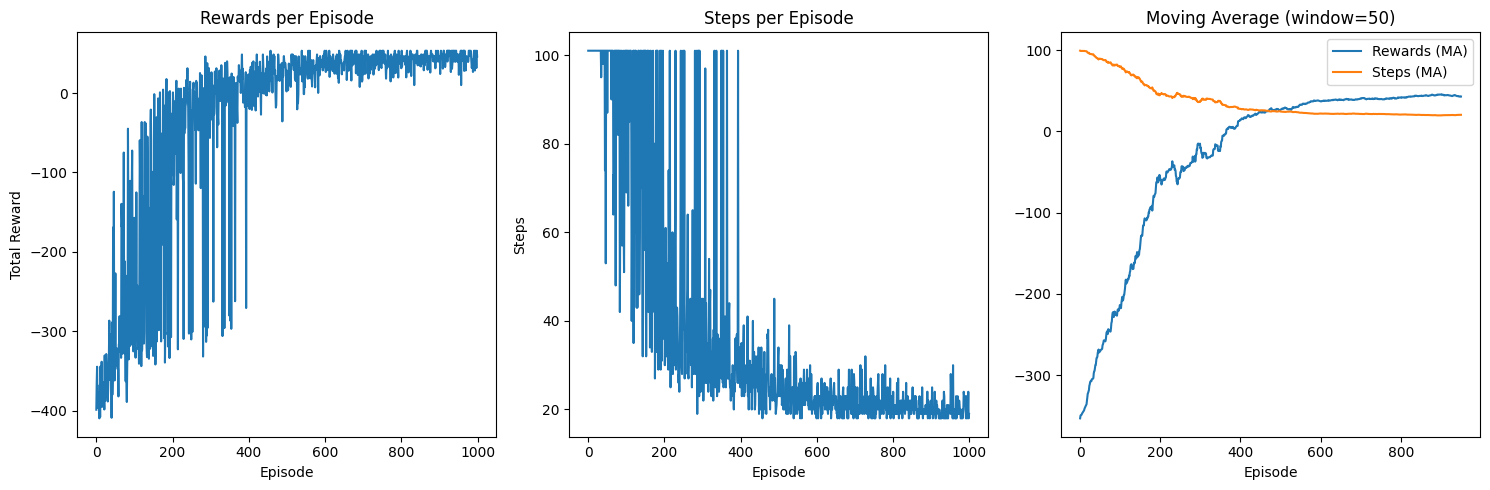

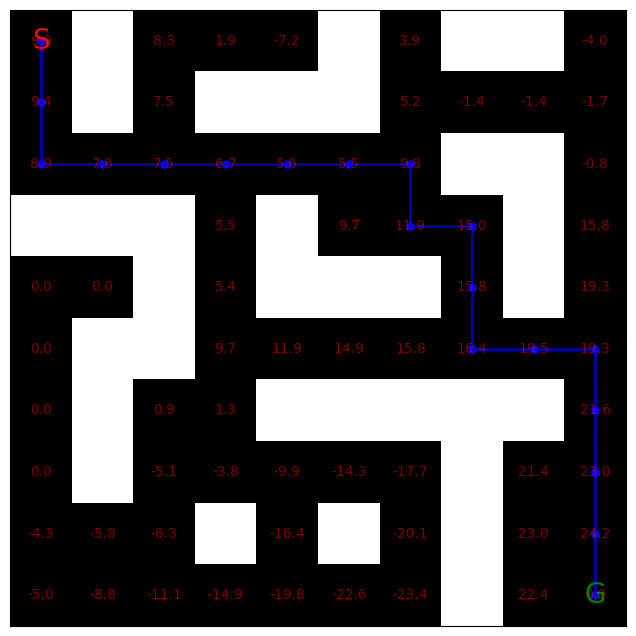

In [11]:
agent = ImprovedQLearningAgent(maze)
rewards, steps, best_path = train_improved_agent(agent, maze, num_episodes=1000)
visualize_training_results(rewards, steps)
maze.show_maze(path=best_path, q_values=agent.q_table)

In [12]:
def save_agent(agent, filename):
    """Save the trained agent's Q-table and parameters"""
    save_dict = {
        'q_table': agent.q_table,
        'target_q_table': agent.target_q_table,
        'replay_buffer': list(agent.replay_buffer),
        'learning_rate': agent.learning_rate,
        'discount_factor': agent.discount_factor,
        'exploration_start': agent.exploration_start,
        'exploration_end': agent.exploration_end
    }
    with open(filename, 'wb') as f:
        pickle.dump(save_dict, f)

In [13]:
# Save the trained agent
save_agent(agent, '/kaggle/working/trained_maze_agent.pkl')
print("Agent saved successfully!")

Agent saved successfully!


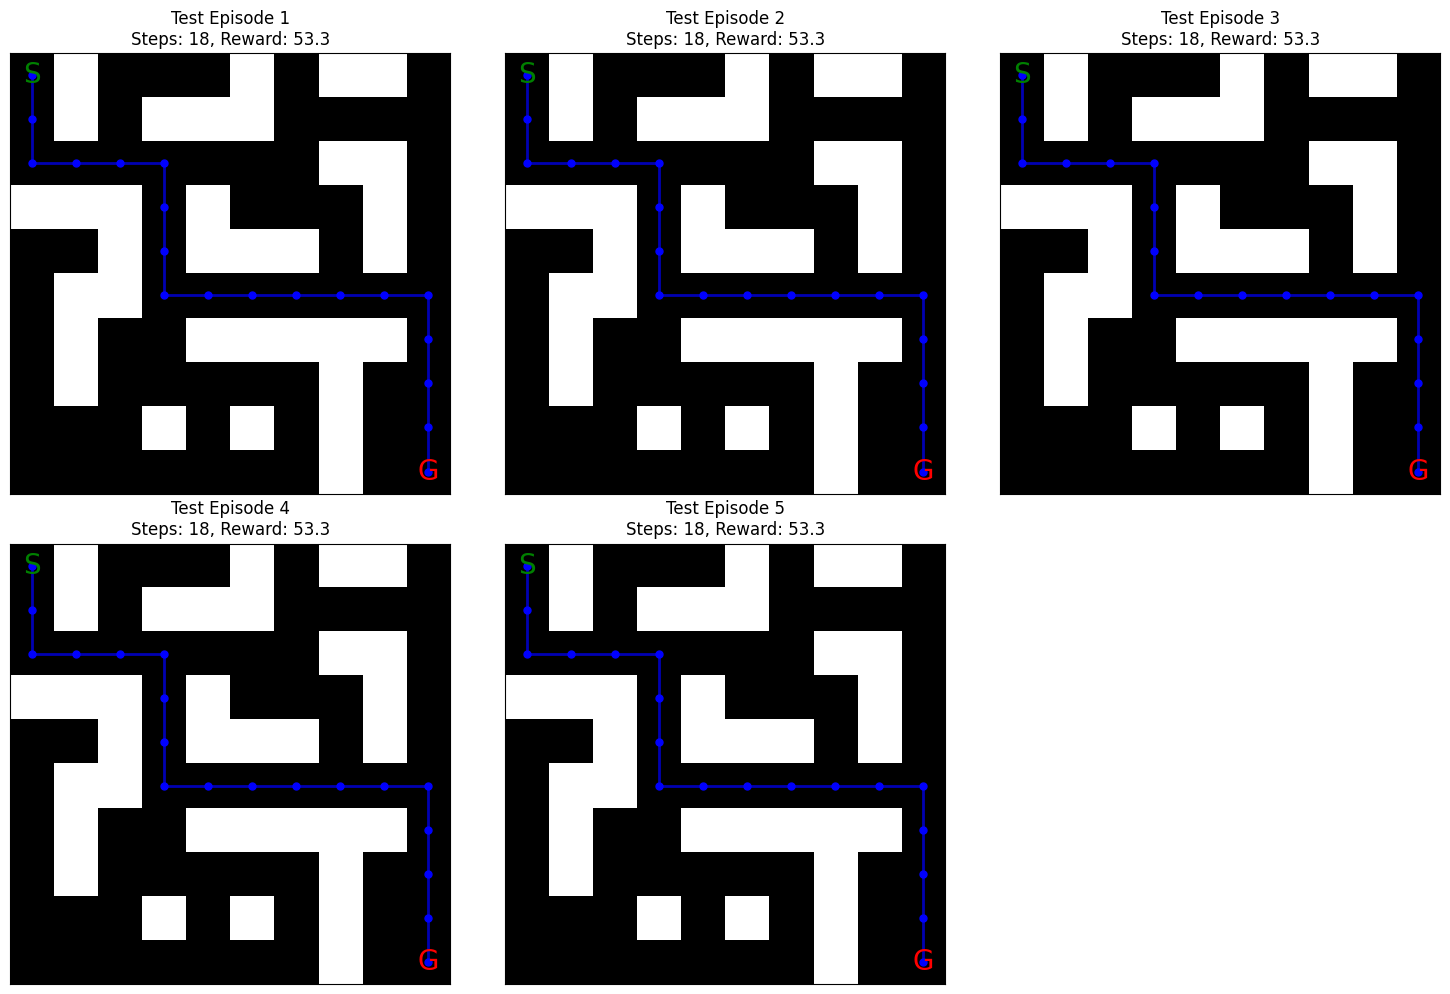


Test Results:
Steps taken: 18
Total reward: 53.28
Successfully reached the goal!


In [14]:
def test_trained_agent(agent, maze, num_episodes=5):
    plt.figure(figsize=(15, 10))
    
    for episode in range(num_episodes):
        current_state = maze.start_position
        path = [current_state]
        steps = 0
        total_reward = 0
        
        while steps < 100:  # Limit steps to prevent infinite loops
            # Get action using trained Q-table (no exploration)
            state_q_values = agent.q_table[current_state[0], current_state[1]]
            action = np.argmax(state_q_values)  # Choose best action
            
            # Calculate next state
            next_state = (
                current_state[0] + actions[action][0],
                current_state[1] + actions[action][1]
            )
            
            # Check if move is valid
            if (next_state[0] < 0 or next_state[0] >= maze.maze_width or
                next_state[1] < 0 or next_state[1] >= maze.maze_height or
                maze.maze[next_state[1]][next_state[0]] == 1):
                next_state = current_state
            
            # Calculate reward
            done = next_state == maze.goal_position
            reward = enhanced_reward_function(current_state, next_state, maze, done, steps)
            
            current_state = next_state
            path.append(current_state)
            total_reward += reward
            steps += 1
            
            if done:
                break
        
        # Plot each episode
        plt.subplot(2, 3, episode + 1)
        plt.imshow(maze.maze, cmap='gray')
        
        # Plot the path
        path = np.array(path)
        plt.plot(path[:, 0], path[:, 1], 'b-', linewidth=2, alpha=0.7)
        plt.plot(path[:, 0], path[:, 1], 'b.', markersize=10)
        
        # Mark start and goal
        plt.text(maze.start_position[0], maze.start_position[1], 'S', 
                ha='center', va='center', color='green', fontsize=20)
        plt.text(maze.goal_position[0], maze.goal_position[1], 'G', 
                ha='center', va='center', color='red', fontsize=20)
        
        plt.title(f'Test Episode {episode + 1}\nSteps: {steps}, Reward: {total_reward:.1f}')
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\nTest Results:")
    print(f"Steps taken: {steps}")
    print(f"Total reward: {total_reward:.2f}")
    if done:
        print("Successfully reached the goal!")
    else:
        print("Failed to reach the goal within step limit.")

# Test the trained agent
# Assuming 'agent' is your trained ImprovedQLearningAgent
test_trained_agent(agent, maze)